Processing angle 10/89
Processing angle 20/89
Processing angle 30/89
Processing angle 40/89
Processing angle 50/89
Processing angle 60/89
Processing angle 70/89
Processing angle 80/89
Execution time: 0.13 seconds
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Materials have no loss and no gain


C:\Users\Lavan\AppData\Local\Temp\ipykernel_13288\3384689862.py:107: RuntimeWarning: invalid value encountered in sqrt
  kz[ii] = np.sqrt((ER[ii] * UR[ii]) - kx**2 - ky**2)


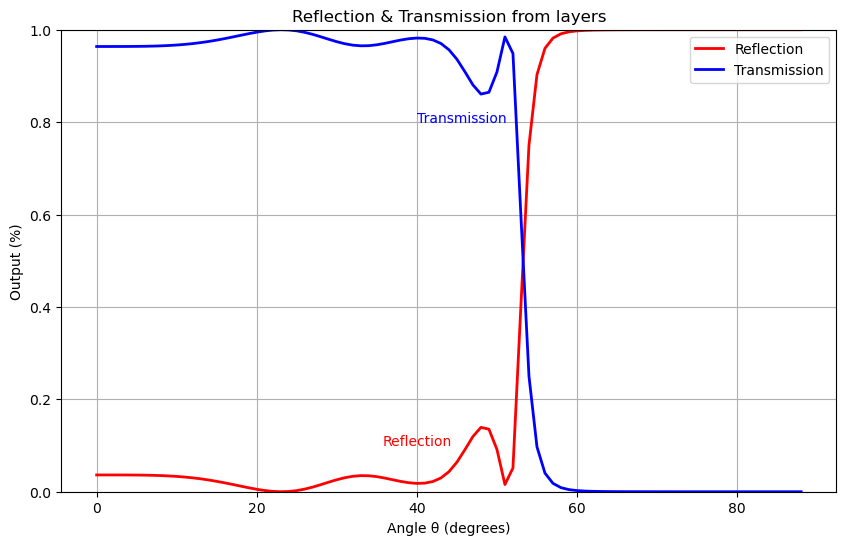

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.linalg import inv, sqrtm, expm, pinv

# Start timer
start_time = time.time()

# Units
deg = np.pi / 180  # Convert angle to degrees
mic = 1e-6  # Convert units to micrometer

# Simulation parameters
lam0 = 1  # Free space wavelength

# Arrays to store results
ref = []
trn = []
ff = []

# Main loop over angles
theta_values = np.arange(0, 89, 1) * deg
jj = 0

for theta in theta_values:
    phi = 0 * deg  # Azimuthal angle
    pte = 0  # TE polarization amplitude
    ptm = 1  # TM polarization amplitude
    
    # External materials
    ur1 = 1  # Permeability of reflection layer
    er1 = 1.5  # Permittivity of reflection layer
    ur2 = 1  # Permeability of transmission layer
    er2 = 1.5  # Permittivity of transmission layer
    
    # Define layers
    UR = np.array([1, 1.4, 1])  # Array of permeabilities in each layer
    ER = np.array([1, 1.4, 1])  # Array of permittivities in each layer
    L = np.array([0.8, 0.5, 0.8]) * lam0  # Array of layer thicknesses
    
    # Implement Transfer Matrix Method
    ninc = np.sqrt(ur1 * er1)  # Incident refractive index
    k0 = 2 * np.pi / lam0  # Free space wave number
    
    kinc = ninc * np.array([
        np.sin(theta) * np.cos(phi),
        np.sin(theta) * np.sin(phi),
        np.cos(theta)
    ])  # kx, ky and kz normalized by k0
    
    kx = kinc[0]  # Wave number along x axis
    ky = kinc[1]  # Wave number along y axis
    
    # Define gap Layer
    urh = 1  # Permeability of gap layer (artificial layer)
    erh = 1 + (kx**2) + (ky**2)  # Permittivity of gap layer (artificial layer)
    
    Qh = (1 / urh) * np.array([
        [kx * ky, (urh * erh) - (kx**2)],
        [(ky**2) - (urh * erh), -kx * ky]
    ])
    
    Vh = -1j * Qh
    Wh = np.eye(2)
    
    # Device Scattering Matrix
    SG = {
        'S11': np.zeros((2, 2), dtype=complex),
        'S12': np.eye(2, dtype=complex),
        'S21': np.eye(2, dtype=complex),
        'S22': np.zeros((2, 2), dtype=complex)
    }
    
    nlay = len(L)  # Number of layers
    
    # Arrays to store matrices
    Q = np.zeros((2, 2, nlay), dtype=complex)
    P = np.zeros((2, 2, nlay), dtype=complex)
    kz = np.zeros(nlay, dtype=complex)
    OMEGA = np.zeros((2, 2, nlay), dtype=complex)
    W_mat = np.zeros((2, 2, nlay), dtype=complex)
    LAM2 = np.zeros((2, 2, nlay), dtype=complex)
    V = np.zeros((2, 2, nlay), dtype=complex)
    X = np.zeros((2, 2, nlay), dtype=complex)
    A = np.zeros((2, 2, nlay), dtype=complex)
    B = np.zeros((2, 2, nlay), dtype=complex)
    
    S = {
        'S11': np.zeros((2, 2, nlay), dtype=complex),
        'S12': np.zeros((2, 2, nlay), dtype=complex),
        'S21': np.zeros((2, 2, nlay), dtype=complex),
        'S22': np.zeros((2, 2, nlay), dtype=complex)
    }
    
    # Main loop through layers
    for ii in range(nlay):
        Q[:, :, ii] = (1 / UR[ii]) * np.array([
            [kx * ky, (ER[ii] * UR[ii]) - (kx**2)],
            [(ky**2) - (ER[ii] * UR[ii]), -kx * ky]
        ])
        
        P[:, :, ii] = (1 / ER[ii]) * np.array([
            [kx * ky, (ER[ii] * UR[ii]) - (kx**2)],
            [(ky**2) - (ER[ii] * UR[ii]), -kx * ky]
        ])
        
        kz[ii] = np.sqrt((ER[ii] * UR[ii]) - kx**2 - ky**2)
        
        try:
            OMEGA[:, :, ii] = sqrtm(P[:, :, ii] @ Q[:, :, ii])
        except:
            # If sqrtm fails, use alternative method
            OMEGA[:, :, ii] = P[:, :, ii] @ Q[:, :, ii]
        
        # Calculate eigenvalues and eigenvectors
        eigvals, eigvecs = np.linalg.eig(OMEGA[:, :, ii])
        W_mat[:, :, ii] = eigvecs
        LAM2[:, :, ii] = np.diag(eigvals)
        
        # Use pinv instead of inv to avoid singular matrix error
        try:
            V[:, :, ii] = Q[:, :, ii] @ W_mat[:, :, ii] @ inv(LAM2[:, :, ii])
        except:
            V[:, :, ii] = Q[:, :, ii] @ W_mat[:, :, ii] @ pinv(LAM2[:, :, ii])
        
        X[:, :, ii] = expm(LAM2[:, :, ii] * k0 * L[ii])
        
        try:
            A[:, :, ii] = inv(W_mat[:, :, ii]) @ Wh + inv(V[:, :, ii]) @ Vh
            B[:, :, ii] = inv(W_mat[:, :, ii]) @ Wh - inv(V[:, :, ii]) @ Vh
        except:
            A[:, :, ii] = pinv(W_mat[:, :, ii]) @ Wh + pinv(V[:, :, ii]) @ Vh
            B[:, :, ii] = pinv(W_mat[:, :, ii]) @ Wh - pinv(V[:, :, ii]) @ Vh
        
        try:
            temp_inv = inv(A[:, :, ii] - X[:, :, ii] @ B[:, :, ii] @ inv(A[:, :, ii]) @ X[:, :, ii] @ B[:, :, ii])
        except:
            temp_inv = pinv(A[:, :, ii] - X[:, :, ii] @ B[:, :, ii] @ pinv(A[:, :, ii]) @ X[:, :, ii] @ B[:, :, ii])
        
        S['S11'][:, :, ii] = temp_inv @ (X[:, :, ii] @ B[:, :, ii] @ pinv(A[:, :, ii]) @ X[:, :, ii] @ A[:, :, ii] - B[:, :, ii])
        S['S12'][:, :, ii] = temp_inv @ X[:, :, ii] @ (A[:, :, ii] - B[:, :, ii] @ pinv(A[:, :, ii]) @ B[:, :, ii])
        S['S21'][:, :, ii] = S['S12'][:, :, ii]
        S['S22'][:, :, ii] = S['S11'][:, :, ii]
        
        # Update device scattering matrix
        try:
            D = SG['S12'] @ inv(np.eye(2) - (S['S11'][:, :, ii] @ SG['S22']))
            F = S['S21'][:, :, ii] @ inv(np.eye(2) - SG['S22'] @ S['S11'][:, :, ii])
        except:
            D = SG['S12'] @ pinv(np.eye(2) - (S['S11'][:, :, ii] @ SG['S22']))
            F = S['S21'][:, :, ii] @ pinv(np.eye(2) - SG['S22'] @ S['S11'][:, :, ii])
        
        SG['S11'] = SG['S11'] + D @ S['S11'][:, :, ii] @ SG['S21']
        SG['S12'] = D @ S['S12'][:, :, ii]
        SG['S21'] = F @ SG['S21']
        SG['S22'] = S['S22'][:, :, ii] + F @ SG['S22'] @ S['S12'][:, :, ii]
    
    # Calculate wave numbers for reflection and transmission
    kzref = -np.conj(np.sqrt((ur1 * er1) - kx**2 - ky**2))
    kztrn = np.conj(np.sqrt((ur2 * er2) - kx**2 - ky**2))
    
    # Compute Reflection Side Connection S-Matrix
    Qref = (1 / ur1) * np.array([
        [kx * ky, ur1 * er1 - kx**2],
        [ky**2 - ur1 * er1, -ky * kx]
    ], dtype=complex)
    
    Wref = np.eye(2, dtype=complex)
    lamref = np.array([[-1j * kzref, 0], [0, -1j * kzref]], dtype=complex)
    
    try:
        Vref = Qref @ inv(lamref)
    except:
        Vref = Qref @ pinv(lamref)
    
    try:
        Aref = inv(Wh) @ Wref + inv(Vh) @ Vref
        Bref = inv(Wh) @ Wref - inv(Vh) @ Vref
    except:
        Aref = pinv(Wh) @ Wref + pinv(Vh) @ Vref
        Bref = pinv(Wh) @ Wref - pinv(Vh) @ Vref
    
    try:
        Sref = {
            'S11': -inv(Aref) @ Bref,
            'S12': 2 * inv(Aref),
            'S21': 0.5 * (Aref - Bref @ inv(Aref) @ Bref),
            'S22': Bref @ inv(Aref)
        }
    except:
        Sref = {
            'S11': -pinv(Aref) @ Bref,
            'S12': 2 * pinv(Aref),
            'S21': 0.5 * (Aref - Bref @ pinv(Aref) @ Bref),
            'S22': Bref @ pinv(Aref)
        }
    
    # Compute Transmission Side Connection S-Matrix
    Qtrn = (1 / ur2) * np.array([
        [kx * ky, er2 * ur2 - kx**2],
        [ky**2 - er2 * ur2, -ky * kx]
    ], dtype=complex)
    
    Wtrn = np.eye(2, dtype=complex)
    lamtrn = np.array([[1j * kztrn, 0], [0, 1j * kztrn]], dtype=complex)
    
    try:
        Vtrn = Qtrn @ inv(lamtrn)
    except:
        Vtrn = Qtrn @ pinv(lamtrn)
    
    try:
        Atrn = inv(Wh) @ Wtrn + inv(Vh) @ Vtrn
        Btrn = inv(Wh) @ Wtrn - inv(Vh) @ Vtrn
    except:
        Atrn = pinv(Wh) @ Wtrn + pinv(Vh) @ Vtrn
        Btrn = pinv(Wh) @ Wtrn - pinv(Vh) @ Vtrn
    
    try:
        Strn = {
            'S11': Btrn @ inv(Atrn),
            'S12': 0.5 * (Atrn - Btrn @ inv(Atrn) @ Btrn),
            'S21': 2 * inv(Atrn),
            'S22': -inv(Atrn) @ Btrn
        }
    except:
        Strn = {
            'S11': Btrn @ pinv(Atrn),
            'S12': 0.5 * (Atrn - Btrn @ pinv(Atrn) @ Btrn),
            'S21': 2 * pinv(Atrn),
            'S22': -pinv(Atrn) @ Btrn
        }
    
    # Compute Global Scattering Matrix
    for nn in range(2):
        if nn == 0:
            SA = Sref.copy()
            SB = SG.copy()
        else:
            SA = SG.copy()
            SB = Strn.copy()
        
        try:
            D = SA['S12'] @ inv(np.eye(2) - SB['S11'] @ SA['S22'])
            F = SB['S21'] @ inv(np.eye(2) - SA['S22'] @ SB['S11'])
        except:
            D = SA['S12'] @ pinv(np.eye(2) - SB['S11'] @ SA['S22'])
            F = SB['S21'] @ pinv(np.eye(2) - SA['S22'] @ SB['S11'])
        
        SG['S11'] = SA['S11'] + D @ SB['S11'] @ SA['S21']
        SG['S12'] = D @ SB['S12']
        SG['S21'] = F @ SA['S21']
        SG['S22'] = SB['S22'] + F @ SA['S22'] @ SB['S12']
    
    # Compute Reflected and Transmitted Fields
    n = np.array([0, 0, 1])  # Polarization unit vector (only along z)
    
    if theta == 0:
        ate = np.array([0, 1, 0])  # Unit vector of TE Polarization
    else:
        cross_prod = np.cross(n, kinc)
        ate = -1 * cross_prod / np.linalg.norm(cross_prod)
    
    atm = np.cross(ate, kinc) / np.linalg.norm(np.cross(ate, kinc))  # Unit vector of TM Polarization
    
    P = -((pte * ate) + (ptm * atm))
    
    # Compute Source Field
    Esrcx = P[0]
    Esrcy = P[1]
    
    # Compute Delta vector
    esrc = np.array([[Esrcx], [Esrcy]], dtype=complex)  # Source Field
    
    # REFLECTED FIELDS
    eref = SG['S11'] @ esrc
    Exref = eref[0, 0]
    Eyref = eref[1, 0]
    
    # TRANSMITTED FIELDS
    etrn = SG['S21'] @ esrc
    Extrn = etrn[0, 0]
    Eytrn = etrn[1, 0]
    
    # Calculate Longitudinal Field Components
    Ezref = (kx * Exref + ky * Eyref) / kzref
    Eztrn = -(kx * Extrn + ky * Eytrn) / kztrn
    
    Eref2 = abs(Exref)**2 + abs(Eyref)**2 + abs(Ezref)**2
    Etrn2 = abs(Extrn)**2 + abs(Eytrn)**2 + abs(Eztrn)**2
    
    REF = Eref2.real
    TRN = -(Etrn2 * np.real((ur1 * kztrn) / (ur2 * kzref))).real
    
    CON = REF + TRN
    
    # Store results
    ref.append(REF)
    trn.append(TRN)
    ff.append(theta)
    jj += 1

    if jj % 10 == 0:
        print(f"Processing angle {jj}/89")

# End timer
end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")
print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

# Check material properties
if np.max(CON) > 1:
    print('Materials have gain')
elif np.allclose(CON, 1):
    print('Materials have no loss and no gain')
else:
    print('Materials have loss')

# Plot results
ff_deg = np.array(ff) * 180 / np.pi

plt.figure(figsize=(10, 6))
plt.plot(ff_deg, ref, 'r', linewidth=2, label='Reflection')
plt.plot(ff_deg, trn, 'b', linewidth=2, label='Transmission')
plt.title('Reflection & Transmission from layers')
plt.xlabel('Angle θ (degrees)')
plt.ylabel('Output (%)')
plt.legend()
plt.grid(True)
plt.text(40, 0.8, 'Transmission', color='b', horizontalalignment='left')
plt.text(40, 0.1, 'Reflection', color='r', horizontalalignment='center')
plt.ylim(0, 1)
plt.show()